# 301.1. 47 Tuc Field

<div style="max-width:300px; float: left; margin-right: 1em">

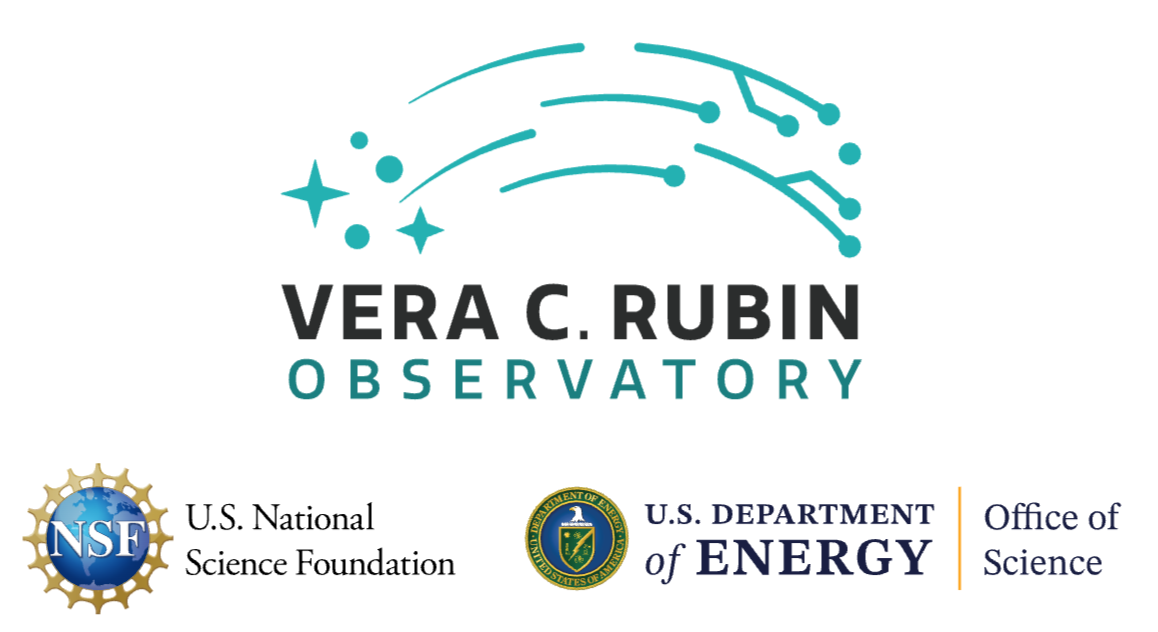

</div>

For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io/">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-09-17 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** An overview of the LSSTComCam data in the "47 Tuc Globular Cluster" 47_Tuc field.

**LSST data products:** `deepCoadd`, `Visit`, `Object`, `CcdVisit`

**Packages:** `lsst.rsp`, `lsst.daf.butler`, `lsst.afw.display`

**Credit:**
Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook examines the DP1 data products in the "47 Tuc" field: assess sky coverage and depth, visit distribution over time, image quality, and the distributions of stars and galaxies in color-magnitude and color-color diagrams (CMD and CCD). 

47 Tucanae ("47 Tuc") is a bright, dense star cluster in the constellation Tucana. The ComCam field targeting this cluster is centered at (RA, Dec) = (6.128, –72.090) degrees. It is representative of the crowded fields that LSST will encounter in the Milky Way. 47 Tuc overlaps with the Small Magellanic Cloud (SMC) on the sky, but these are distinct objects: 47 Tuc is a globular cluster of the Milky Way's halo, while the SMC is a dwarf satellite galaxy orbiting around the Milky Way. 

**Related tutorials:** The 100-level tutorials demonstrate how to use the butler, the TAP service, and the Firefly image display. The 200-level tutorials introduce the types of image and catalog data.


### 1.1. Import packages

Import `numpy`, a fundamental package for scientific computing with arrays in Python (<a href="https://numpy.org">numpy.org</a>), and `matplotlib`, a comprehensive library for data visualization (<a href="https://matplotlib.org/">matplotlib.org</a>; <a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>), including custom shapes (`Polygon`) and lines (`mlines`). `itertools` supports efficient iteration and combinatorics.

From the `lsst` package, import modules for accessing the Table Access Protocol (TAP) service, for retrieving datasets from the butler, and for image displaying from the LSST Science Pipelines (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>). Additional modules support spherical geometry (`sphgeom`), 2D geometry (`geom`), and standardized multiband plotting (`lsst.utils.plotting`) for LSST data analysis and visualization.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.lines as mlines
import itertools

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.afw.display as afw_display
import lsst.sphgeom as sphgeom
import lsst.geom as geom
from lsst.utils.plotting import (
    get_multiband_plot_colors,
    get_multiband_plot_symbols,
    get_multiband_plot_linestyles,
)

### 1.2. Define parameters and functions

Create an instance of the TAP service, and assert that it exists.

In [ ]:
service = get_tap_service("tap")
assert service is not None

Create an instance of the butler, and assert that it exists.

In [ ]:
butler = Butler('dp1', collections="LSSTComCam/DP1")
assert butler is not None

Define the approximate central coordinates of the 47 Tuc field, and the `region` within 1 degree of this center.

In [ ]:
ra_cen = 6.128
dec_cen = -72.090
radius = 1.0

region = sphgeom.Region.from_ivoa_pos(f"CIRCLE {ra_cen} {dec_cen} {radius}")

Define parameters to use colorblind-friendly colors with `matplotlib`.

In [ ]:
plt.style.use('seaborn-v0_8-colorblind')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Define colors, symbols, and linestyles to represent the six LSST filters, $ugrizy$.

In [ ]:
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()
filter_linestyles = get_multiband_plot_linestyles()

Set `afwDisplay` to use Firefly to display images, and open Firefly frame 1.

In [ ]:
afw_display.setDefaultBackend('firefly')
display = afw_display.Display(frame=1)

## 2. Coadd sky coverage and depth

The individual LSSTComCam images have been combined (stacked) into `deep_coadd` images, and sky maps of the accumulated exposure time and image depth have been created.

### 2.1. Display a deep coadd

Query the butler for all $r$-band `deep_coadd` images that overlap the defined `region`.

In [ ]:
query = "patch.region OVERLAPS region AND band='r'"
coadd_datasetrefs = butler.query_datasets("deep_coadd",
                                          where=query,
                                          bind={"region": region},
                                          with_dimension_records=True,
                                          order_by=["patch.tract"])

In [ ]:
print('There are %s r-band deep_coadd images.' % len(coadd_datasetrefs))

Retrieve the `deep_coadd` image associated with the first of the dataset references returned by the butler query.

In [ ]:
coadd = butler.get(coadd_datasetrefs[0])

Display the image, and set the mask plane to be fully transparent.

In [ ]:
display.mtv(coadd)
display.setMaskTransparency(100)

### 2.2. Exposure time and depth

Retrieve the entire survey property map of the $r$-band magnitude limit as `hspmap_rmaglim`,
and of the total $r$-band exposure time as `hspmap_rexptime`.

In [ ]:
hspmap_rexptime = butler.get('deepCoadd_exposure_time_consolidated_map_sum',
                             skymap='lsst_cells_v1', band='r')
hspmap_rmaglim = butler.get('deepCoadd_psf_maglim_consolidated_map_weighted_mean',
                            skymap='lsst_cells_v1', band='r')

Extract the healsparse map values within the radius of the field center and divide the region into a 250×250 grid.
Evaluate each survey property map at these grid points.
Replace all negative values (no-data placeholders) with NaN to enable proper map display.

In [ ]:
dec_size = radius
ra_size = dec_size / np.cos(np.radians(dec_cen))
ra_min, ra_max = ra_cen - ra_size, ra_cen + ra_size
dec_min, dec_max = dec_cen - dec_size, dec_cen + dec_size

ra = np.linspace(ra_min, ra_max, 250)
dec = np.linspace(dec_min, dec_max, 250)
x, y = np.meshgrid(ra, dec)

values_rmaglim = hspmap_rmaglim.get_values_pos(x, y)
values_rmaglim = np.where(values_rmaglim < 0.0, np.nan, values_rmaglim)

values_rexptime = hspmap_rexptime.get_values_pos(x, y)
values_rexptime = np.where(values_rexptime < 0.0, np.nan, values_rexptime)

Clean up.

In [ ]:
del ra, dec

Print the mean, median, and min/max values for the $r$-band magnitude limit and exposure time. Exposure times are accumulated over multiple visits, not single exposures. 

In [ ]:
print('r-band magnitude limit mean/median: %5.2f %5.2f' %
      (np.nanmean(values_rmaglim), np.nanmedian(values_rmaglim)))
print('r-band magnitude min/max: %5.2f %5.2f' %
      (np.nanmin(values_rmaglim), np.nanmax(values_rmaglim)))
print('r-band exposure time (s) mean/median: %5.1f %5.1f' %
      (np.nanmean(values_rexptime), np.nanmedian(values_rexptime)))
print('r-band exposure time min/max (s): %5.1f %5.1f' %
      (np.nanmin(values_rexptime), np.nanmax(values_rexptime)))

### 2.3. Coverage map

Define unique colors and linestyles for plotting each of the tracts in the dataset.

In [ ]:
alltracts = [rec.dataId['tract'] for rec in coadd_datasetrefs]
unique_tracts = np.unique(alltracts)

tract_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_tracts)))
linestyles = ['-', '--', '-.', ':'] * ((len(unique_tracts) // 4) + 1)

style_dict = {
    tract: {'color': tract_colors[i], 'linestyle': linestyles[i]}
    for i, tract in enumerate(unique_tracts)
}

The `coadd_datasetrefs` returned from the butler include region information for each dataset, stored as a `ConvexPolygon3D` with four vertices defining the sky footprint of each overlapping tract and patch.

Convert these vertices to 2D sky coordinates (RA, Dec) using `geom.SpherePoint`, and use `matplotlib.patches.Polygon` along with `ax.add_patch()` to draw each patch outline. Each tract is plotted with a distinct color and linestyle for visual clarity.

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

mesh = ax.pcolormesh(x, y, values_rmaglim, cmap='Greys_r', shading='auto')
fig.colorbar(mesh, ax=ax, label="r-band limiting magnitude (mag)")

for rec in coadd_datasetrefs:
    vertices = rec.dataId.patch.region.getVertices()
    vertices_deg = []
    for vertex in vertices:
        vertices_deg.append([geom.SpherePoint(vertex).getRa().asDegrees(),
                             geom.SpherePoint(vertex).getDec().asDegrees()])
    polygon = Polygon(vertices_deg, closed=True, facecolor='None',
                      edgecolor=style_dict[rec.dataId['tract']]['color'],
                      linestyle=style_dict[rec.dataId['tract']]['linestyle'],
                      linewidth=2)
    ax.add_patch(polygon)

ax.set_xlim(ra_max, ra_min)
ax.set_ylim(dec_min, dec_max)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')

handles = [
    mlines.Line2D(
        [], [],
        color=style['color'],
        linestyle=style['linestyle'],
        label=f"Tract {tract}"
    )
    for tract, style in style_dict.items()
]
ax.legend(handles=handles, loc='upper left', ncol=2)

ax.minorticks_on()

plt.tight_layout()
plt.show()

> **Figure 1:** $r$-band limiting magnitude map for the 47 Tuc field, shown in greyscale, overplotted with the patch boundaries colored by their tract number (as in the legend). The core of 47 Tuc is saturated in the LSSTComCam commissioning images, resulting in missing coadds in that region. 

Clean up.

In [ ]:
del coadd_datasetrefs
del hspmap_rmaglim, hspmap_rexptime
del x, y, values_rmaglim, values_rexptime
del style_dict

## 3. Visits (observations)

Retrieve all visits (individual observations of the sky) that fall within a circular region centered at (RA, Dec) = (`ra_cen`, `dec_cen`) with a `radius` of 1 degree. Return the visit ID, band, observation midpoint time in both MJD and calendar date.

In [ ]:
query = """SELECT visit, band, expMidptMJD, expMidpt
        FROM dp1.Visit
        WHERE CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS', {}, {}, {}))=1
        """.format(ra_cen, dec_cen, radius)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

In [ ]:
assert job.phase == 'COMPLETED'
visits = job.fetch_result().to_table()
print(f"Total number of visits: {len(visits)}")

Option to display the table of results.

In [ ]:
# visits

### 3.1. Filter distribution

Count and list the number of visits per filter.

In [ ]:
all_bands = np.array([visit['band'] for visit in visits], dtype=str)
unique_bands, counts = np.unique(all_bands, return_counts=True)

for band, count in zip(unique_bands, counts):
    print(band, count)

*Note:* no $u$-band observations for 47 Tuc pass the DP1 quality cuts.

Create a list of only the filters observed for this field to use below.

In [ ]:
field_filters = ['g', 'r', 'i', 'y']

Clean up.

In [ ]:
del all_bands, unique_bands, counts

### 3.2. Visit dates

Plot two characteristics of the visit dates:

1. Plot the cumulative distribution of visit dates for each of the four bands ($griy$).
2. Plot the distribution of the time separation between visits for each band and for all bands combined.

In [ ]:
t_start = visits[0]['expMidptMJD'] - 1.0
t_end = visits[-1]['expMidptMJD'] + 1.0
time_bins = np.arange(t_end - t_start, dtype='int') + t_start
diff_bins = np.arange(0, np.max(time_bins) - np.min(time_bins) + 3, 1)
all_time_diffs = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

for band in field_filters:
    mjds = sorted([
        visit['expMidptMJD']
        for visit in visits
        if visit['band'] == band
    ])
    mjds = np.array(mjds, dtype=float)
    label = f"{band} ({len(mjds)})"

    counts, _, patches = ax1.hist(
        mjds, bins=time_bins, cumulative=True, histtype='step',
        linewidth=2, color=filter_colors[band], label=label
    )
    for patch in patches:
        patch.set_linestyle(filter_linestyles[band])

    tdiffs = []
    for comb in itertools.combinations(mjds, 2):
        tdiffs.append(comb[1] - comb[0])
    time_diffs = np.array(tdiffs)
    all_time_diffs.append(time_diffs)

    counts_diff, _, patches_diff = ax2.hist(
        time_diffs, bins=diff_bins, histtype='step', linewidth=2,
        color=filter_colors[band], label=band
    )
    for patch in patches_diff:
        patch.set_linestyle(filter_linestyles[band])

all_time_diffs = np.concatenate(all_time_diffs)
ax2.hist(
    all_time_diffs, bins=diff_bins, histtype='step', linewidth=2,
    color='black', label='all filters'
)

ax1.set_xlabel('Modified Julian Date')
ax1.set_ylabel('Cumulative number of visits')
ax1.minorticks_on()
ax2.set_xlabel('Separation between observations (d)')
ax2.set_ylabel('Number of observations')
ax2.set_yscale('log')
ax2.legend(loc='upper right', ncol=2)
ax2.minorticks_on()
plt.show()

> **Figure 2:** The left panel shows the cumulative number of visits per filter as a function of time. The right panel shows histograms of visit-to-visit time separations for each filter individually (colors), and all together (black).

Clean up.

In [ ]:
del time_bins, all_time_diffs

### 3.3. Visit image quality

Retrieve statistics about the image quality of the individual `visit_images` from the `CcdVisit` table.

In [ ]:
query = """SELECT visitId, ra, dec, band, magLim, seeing
        FROM dp1.CcdVisit
        WHERE CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS', {}, {}, {}))=1
        """.format(ra_cen, dec_cen, radius)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

In [ ]:
assert job.phase == 'COMPLETED'
ccd_visits = job.fetch_result().to_table()

Plot the distribution of `seeing`, which is the mean full width at half maximum of the PSF, for all visits and detector combinations. 

In [ ]:
min_seeing = np.min(ccd_visits['seeing'])
max_seeing = np.max(ccd_visits['seeing'])
seeing_bins = np.arange(min_seeing, max_seeing, 0.05)

fig = plt.figure(figsize=(7, 5))
for band in field_filters:
    print(f"Median in {band}-band: \
            {np.ma.median(ccd_visits[ccd_visits['band'] == band]['seeing']): .2f}")
    n, bins, patches = plt.hist(ccd_visits[ccd_visits['band'] == band]['seeing'],
                                seeing_bins, histtype='step',
                                linewidth=2,
                                color=filter_colors[band],
                                label=band)
    for patch in patches:
        patch.set_linestyle(filter_linestyles[band])

plt.legend(loc='upper right')
plt.xlabel('PSF FWHM (arcsec)')
plt.ylabel('Number of visits')
plt.minorticks_on()
plt.show()

> **Figure 3:** Histogram of delivered image quality of detector images, per filter.

Clean up.

In [ ]:
del seeing_bins

Plot the distribution of the magnitude limit, `magLim`.

In [ ]:
min_mag = np.min(ccd_visits['magLim'])
max_mag = np.max(ccd_visits['magLim'])
maglim_bins = np.arange(min_mag, max_mag, 0.1)

fig = plt.figure(figsize=(7, 5))

for band in field_filters:
    print(f"Median in {band}-band: \
            {np.ma.median(ccd_visits[ccd_visits['band'] == band]['magLim']): .2f}")
    n, bins, patches = plt.hist(ccd_visits[ccd_visits['band'] == band]['magLim'],
                                maglim_bins, histtype='step',
                                linewidth=2,
                                color=filter_colors[band],
                                label=band)
    for patch in patches:
        patch.set_linestyle(filter_linestyles[band])

plt.legend(loc='upper left')
plt.xlabel('limiting magnitude')
plt.ylabel('Number of visits')
plt.minorticks_on()
plt.show()

> **Figure 4:** Histogram of limiting magnitude at signal-to-noise=5 on detector images, per filter.

Clean up.

In [ ]:
del maglim_bins

## 4. Object (detections)

The `Object` table contains forced measurements on the deep coadded images at the locations of all objects detected with signal-to-noise ratio > 5 in a `deep_coadd` of any filter.

Query the `Object` table for objects in the field, and return their coordinates, the value of E(B-V) at their location, and their PSF and `cModel` AB magnitudes.

In [ ]:
query = """SELECT objectId, coord_ra, coord_dec, ebv,
        {}_psfMag, {}_cModelMag, {}_psfMag, {}_cModelMag,
        {}_psfMag, {}_cModelMag, {}_psfMag, {}_cModelMag,
        refExtendedness
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
              CIRCLE('ICRS', {}, {}, {})) = 1
        """.format(field_filters[0], field_filters[0],
                   field_filters[1], field_filters[1],
                   field_filters[2], field_filters[2],
                   field_filters[3], field_filters[3],
                   ra_cen, dec_cen, radius)

In [ ]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
if job.phase == 'ERROR':
    job.raise_if_error()

In [ ]:
assert job.phase == 'COMPLETED'
objtab = job.fetch_result().to_table()

### 4.1. Magnitude distributions

Plot histograms of object magnitudes, separating the samples into stars and galaxies.

Use the `refExtendedness` flag to distinguish them: treat objects with `refExtendedness == 1` as likely galaxies (extended) and those with `refExtendedness == 0` as likely stars (point sources).

Use `cModelMag` mags for galaxies and `psfMag` for stars.

In [ ]:
ptsource = (objtab['refExtendedness'] == 0)

In [ ]:
mag_bins = np.arange(15.4, 28.6, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)

for band in field_filters:
    mag_psf = objtab[f"{band}_psfMag"]
    mag_cmodel = objtab[f"{band}_cModelMag"]

    valid_mags = (15 < mag_psf) & (mag_psf < 30) & (15 < mag_cmodel) & (mag_cmodel < 30)

    print(f"Number of objects in {band}-band: {np.sum(valid_mags)}")

    n_psf, bins_psf, patches_psf = ax1.hist(
        mag_psf[valid_mags & ptsource],
        bins=mag_bins,
        histtype='step',
        linewidth=2,
        color=filter_colors[band],
        label=band,
    )
    for patch in patches_psf:
        patch.set_linestyle(filter_linestyles[band])

    n_cmodel, bins_cmodel, patches_cmodel = ax2.hist(
        mag_cmodel[valid_mags & ~ptsource],
        bins=mag_bins,
        histtype='step',
        linewidth=2,
        color=filter_colors[band],
        label=band,
    )
    for patch in patches_cmodel:
        patch.set_linestyle(filter_linestyles[band])

ax1.set_xlim(mag_bins.min(), mag_bins.max())
ax1.set_yscale('log')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Number of objects')
ax1.set_title('Point sources (PSF mags)')
ax1.legend(loc='upper left', ncols=2)
ax1.minorticks_on()

ax2.set_xlim(mag_bins.min(), mag_bins.max())
ax2.set_xlabel('Magnitude')
ax2.set_title('Extended sources (cModel mags)')
ax2.minorticks_on()

plt.show()

> **Figure 5:** Histogram of object magnitudes separated by morphological type. The left panel shows likely stars (`refExtendedness` = 0) using `PSF` magnitudes, while the right panel shows likely galaxies `cModel` magnitudes. The bump near 19 mag in the stellar distribution corresponds to red clump stars in the SMC.

Clean up.

In [ ]:
del mag_bins, mag_psf, mag_cmodel, valid_mags, n_psf, bins_psf
del patches_psf, n_cmodel, bins_cmodel, patches_cmodel

## 5. Analysis

A short demonstration of some stanard scientific analyses.

### 5.1. CMDs and CCDs

Plot \$r\$ vs. \$(g - r)\$ CMDs and \$(r - i)\$ vs. \$(g - r)\$ CCDs. Create separate plots for stars and galaxies using `PSF` magnitudes for stars and `cModel` magnitudes for galaxies.

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 6),
                                             height_ratios=[1, 2.5])
plt.subplots_adjust(hspace=0, wspace=0)

grmin, grmax = -0.9, 2.3
rimin, rimax = -1.3, 2.8
magmin, magmax = 15.8, 26.8

ax1.hexbin(objtab[ptsource]['g_psfMag']-objtab[ptsource]['r_psfMag'],
           objtab[ptsource]['r_psfMag']-objtab[ptsource]['i_psfMag'],
           gridsize=(150, 150),
           extent=(grmin, grmax, rimin, rimax), bins='log', cmap='Grays')
ax1.set_title('Point sources (PSF mags)')
ax1.set_xlim(grmin, grmax)
ax1.set_ylim(rimin, rimax)
ax1.set_ylabel(r'$(r-i)$')
ax1.set_xticklabels([])
ax1.minorticks_on()

ax2.hexbin(objtab[~ptsource]['g_cModelMag']-objtab[~ptsource]['r_cModelMag'],
           objtab[~ptsource]['r_cModelMag']-objtab[~ptsource]['i_cModelMag'],
           gridsize=(150, 150),
           extent=(grmin, grmax, rimin, rimax), bins='log', cmap='Grays')
ax2.set_title('Extended sources (cModel mags)')
ax2.set_xlim(grmin, grmax)
ax2.set_ylim(rimin, rimax)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.minorticks_on()

ax3.hexbin(objtab[ptsource]['g_psfMag']-objtab[ptsource]['r_psfMag'],
           objtab[ptsource]['r_psfMag'], gridsize=(150, 200),
           extent=(grmin, grmax, magmin, magmax), bins='log', cmap='Grays')
ax3.plot([-0.2, -0.2, 0.6, 0.6, -0.2], [25, 19.5, 19.5, 25, 25], color='Red')
ax3.set_xlim(grmin, grmax)
ax3.set_ylim(magmax, magmin)
ax3.set_xlabel(r'$(g-r)$')
ax3.set_ylabel(r'$r$ magnitude')
ax3.minorticks_on()

ax4.hexbin(objtab[~ptsource]['g_cModelMag']-objtab[~ptsource]['r_cModelMag'],
           objtab[~ptsource]['r_cModelMag'], gridsize=(150, 200),
           extent=(grmin, grmax, magmin, magmax), bins='log', cmap='Grays')
ax4.set_xlim(grmin, grmax)
ax4.set_ylim(magmax, magmin)
ax4.set_xlabel(r'$(g-r)$')
ax4.set_yticklabels([])
ax4.minorticks_on()

plt.show()

> **Figure 6:** CMDs and CCDs for objects classified by morphology. The left column shows likely stars (`refExtendedness` = 0) using `PSF` magnitudes, and the right column shows likely galaxies using `cModel` magnitudes. Top panels display $(r - i)$ vs. $(g - r)$ CCDs; bottom panels show $r$ vs. $(g - r)$ CMDs. 

### 5.2. SMC contamination

The red box in Figure 6 represents stellar populations in the outer SMC. 47 Tuc lies more than 2 degrees from the main body of the SMC, but a diffuse stellar population from the SMC extends into the 47 Tuc field, contributing to the CMD and CCD of 47 Tuc.

The figure below, adapted from [Nidever et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....161...74N/abstract), is based on DECam images acquired through the Survey of the MAgellanic Stellar History (SMASH) program, depicting the sky positions of the two objects.

<div style="max-width:400px">

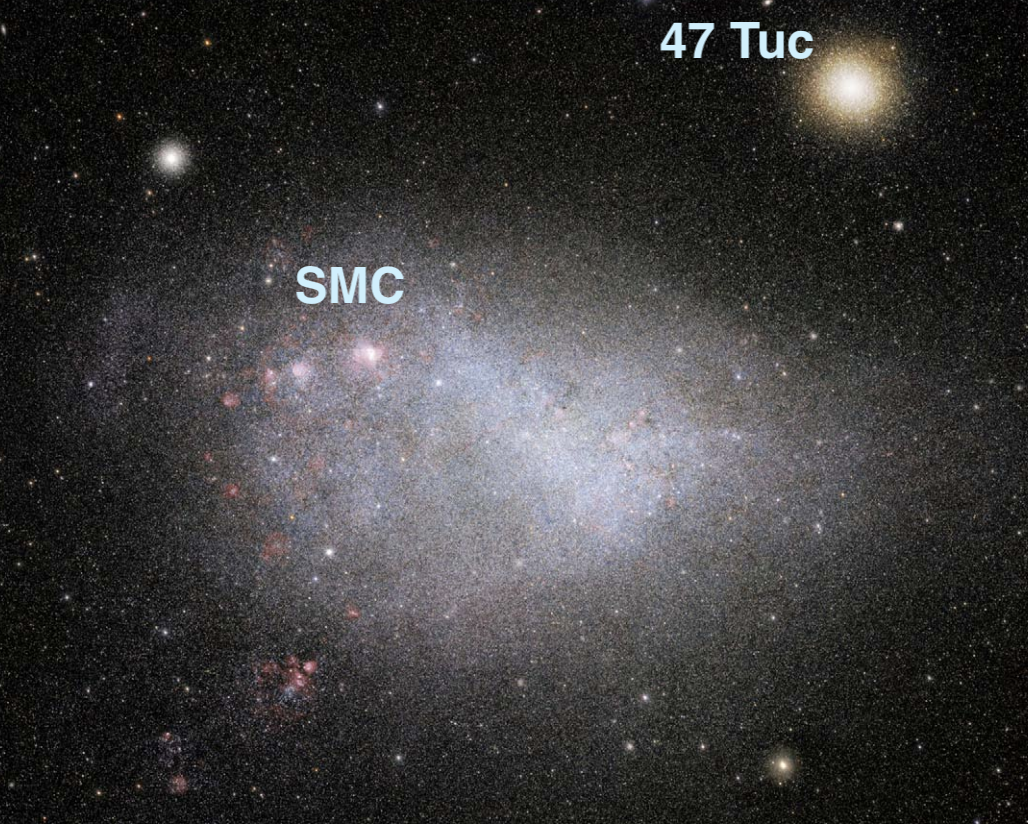

</div>